## 서울 지하철 혼잡도를 고려한 최적 경로 탐색 알고리즘
알고리즘 2025-2학기 기말과제

In [9]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [10]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

In [11]:
import pandas as pd
import heapq
import time
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

edges_df = pd.read_csv(
    "서울교통공사 역간거리 및 소요시간_240810.csv",
    encoding="cp949"
)

transfer_df = pd.read_csv(
    "서울교통공사_환승역거리 소요시간 정보_20250331.csv",
    encoding="cp949"
)

crowd_df = pd.read_csv(
    "서울교통공사_지하철혼잡도정보_20250930.csv",
    encoding="cp949"
)


In [12]:
def time_to_sec(t):
    if isinstance(t, str) and ":" in t:
        m, s = t.split(":")
        return int(m) * 60 + int(s)
    return int(t)

edges_df["소요시간(초)"] = edges_df["소요시간"].apply(time_to_sec)


In [13]:
def get_congestion(line, station, day="평일", time_col="8시00분"):
    df = crowd_df[
        (crowd_df["호선"] == int(line)) &
        (crowd_df["출발역"] == station) &
        (crowd_df["요일구분"] == day)
    ]

    if df.empty or time_col not in crowd_df.columns:
        return crowd_df[time_col].mean()

    return df[time_col].mean()


In [14]:
graph = defaultdict(list)

BETA = 2.0             # 혼잡도 가중치
ALPHA_TRANSFER = 1.0   # 환승 가중치

# 4-1. 같은 호선 내 인접역
edges_sorted = edges_df.sort_values(by=["호선", "연번"])

for line, group in edges_sorted.groupby("호선"):
    group = group.sort_values("연번").reset_index(drop=True)

    for i in range(len(group) - 1):
        s1 = group.loc[i, "역명"]
        s2 = group.loc[i + 1, "역명"]

        base_time = group.loc[i, "소요시간(초)"]
        congestion = get_congestion(line, s1)

        weight = base_time + BETA * congestion

        u = (s1, str(line))
        v = (s2, str(line))

        graph[u].append((v, weight))
        graph[v].append((u, weight))


In [15]:
# 4-2. 환승 간선
for _, row in transfer_df.iterrows():
    station = row["환승역명"]
    line_from = str(row["호선"])
    line_to   = str(row["환승노선"])

    t_time = time_to_sec(row["환승소요시간"])

    u = (station, line_from)
    v = (station, line_to)

    graph[u].append((v, ALPHA_TRANSFER * t_time))
    graph[v].append((u, ALPHA_TRANSFER * t_time))


In [16]:
def dijkstra_with_path(start, end):
    pq = [(0, start)]
    dist = {start: 0}
    prev = {}

    while pq:
        cur_dist, cur = heapq.heappop(pq)

        if cur_dist > dist.get(cur, float("inf")):
            continue

        if cur == end:
            break

        for nxt, w in graph.get(cur, []):
            nd = cur_dist + w
            if nd < dist.get(nxt, float("inf")):
                dist[nxt] = nd
                prev[nxt] = cur
                heapq.heappush(pq, (nd, nxt))

    path = []
    cur = end
    while cur in prev:
        path.append(cur)
        cur = prev[cur]
    path.append(start)
    path.reverse()

    return path, dist.get(end, None)


In [17]:
print("노드 수:", len(graph))

start = ("서울역", "1")
end   = ("강남", "2")

t0 = time.perf_counter()
path, cost = dijkstra_with_path(start, end)
t1 = time.perf_counter()

print("최적 경로:")
for p in path:
    print(p)

print("총 비용:", cost)
print("실행 시간:", t1 - t0)


노드 수: 404
최적 경로:
('서울역', '1')
('시청', '1')
('종각', '1')
('종로3가', '1')
('종로3가', '3호선')
('종로3가', '5')
('을지로4가', '5')
('동대문역사문화공원', '5')
('동대문역사문화공원', '4호선')
('동대문역사문화공원', '2')
('신당', '2')
('상왕십리', '2')
('왕십리', '2')
('한양대', '2')
('뚝섬', '2')
('성수', '2')
('건대입구', '2')
('구의', '2')
('강변', '2')
('잠실나루', '2')
('잠실', '2')
('잠실새내', '2')
('종합운동장', '2')
('삼성', '2')
('선릉', '2')
('역삼', '2')
('강남', '2')
총 비용: 3685.9242369838425
실행 시간: 0.0008755769999879703


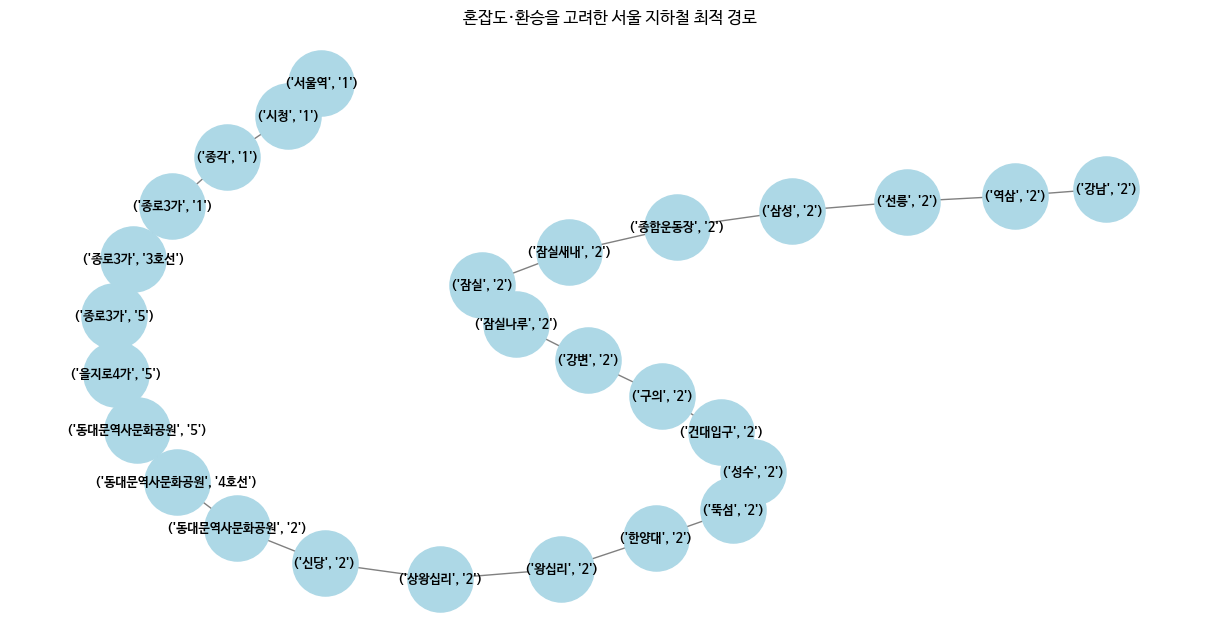

In [21]:
G = nx.Graph()

for i in range(len(path) - 1):
    G.add_edge(path[i], path[i + 1])

plt.figure(figsize=(12, 6))
pos = nx.spring_layout(G, seed=42)

nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=2200,
    node_color="lightblue",
    edge_color="gray",
    font_size=9,
    font_weight="bold",
    font_family="NanumBarunGothic"  # 🔥 이 줄이 핵심
)

plt.title("혼잡도·환승을 고려한 서울 지하철 최적 경로")
plt.show()


In [22]:
print("노드 수:", len(graph))

start = ("철산", "7")
end   = ("월곡", "6")

t0 = time.perf_counter()
path, cost = dijkstra_with_path(start, end)
t1 = time.perf_counter()

print("최적 경로:")
for p in path:
    print(p)

print("총 비용:", cost)
print("실행 시간:", t1 - t0)

노드 수: 404
최적 경로:
('철산', '7')
('가산디지털단지', '7')
('남구로', '7')
('대림', '7')
('신풍', '7')
('보라매', '7')
('신대방삼거리', '7')
('장승배기', '7')
('상도', '7')
('숭실대입구', '7')
('남성', '7')
('이수', '7')
('내방', '7')
('고속터미널', '7')
('고속터미널', '9호선')
('고속터미널', '3')
('잠원', '3')
('신사', '3')
('압구정', '3')
('옥수', '3')
('금호', '3')
('약수', '3')
('동대입구', '3')
('충무로', '3')
('을지로3가', '3')
('종로3가', '3')
('종로3가', '1호선')
('종로3가', '5')
('광화문', '5')
('서대문', '5')
('충정로', '5')
('애오개', '5')
('공덕', '5')
('공덕', '경의중앙선')
('공덕', '6')
('효창공원앞', '6')
('삼각지', '6')
('녹사평', '6')
('이태원', '6')
('한강진', '6')
('버티고개', '6')
('약수', '6')
('청구', '6')
('신당', '6')
('동묘앞', '6')
('창신', '6')
('보문', '6')
('안암', '6')
('고려대', '6')
('월곡', '6')
총 비용: 7633.806463195692
실행 시간: 0.0010184380000737292


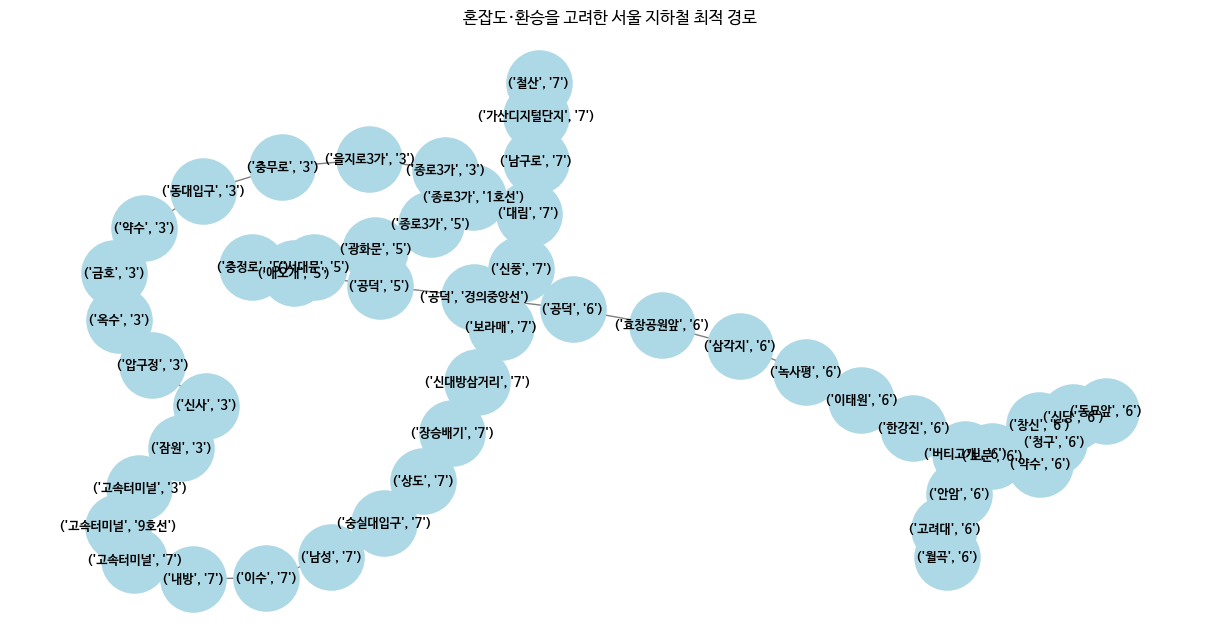

In [23]:
G = nx.Graph()

for i in range(len(path) - 1):
    G.add_edge(path[i], path[i + 1])

plt.figure(figsize=(12, 6))
pos = nx.spring_layout(G, seed=42)

nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=2200,
    node_color="lightblue",
    edge_color="gray",
    font_size=9,
    font_weight="bold",
    font_family="NanumBarunGothic"  # 🔥 이 줄이 핵심
)

plt.title("혼잡도·환승을 고려한 서울 지하철 최적 경로")
plt.show()